# Subgroup B: Demand Forecasting
How can we accurately predict demand for public transport services?
- Develop a demand forecasting model using historical data and survey responses. 
- Identify key factors influencing demand fluctuations. 


## Importing packages

In [73]:
import datetime
import sklearn
import random
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV


## Loading and cleaning data

In [74]:
data = pd.read_csv('synthetic_data.csv')

data['time_start'] = pd.to_datetime(data['time_start'])


def assign_date(row):
    if row['day_of_the_week'] == 'Monday':
        return '2024-09-01'  # Date for Mondays
    elif row['day_of_the_week'] == 'Tuesday':
        return '2024-09-02'  # Date for Tuesdays
    elif row['day_of_the_week'] == 'Wednesday':
        return '2024-09-03'  # Date for Wednesdays
    elif row['day_of_the_week'] == 'Thursday':
        return '2024-09-04'  # Date for Thursdays
    elif row['day_of_the_week'] == 'Friday':
        return '2024-09-05'  # Date for Fridays
    elif row['day_of_the_week'] == 'Saturday':
        return '2024-09-06'  # Date for Saturday
    else:
        return '2024-09-07' 

# Apply the function to create a new date column
data['new_date'] = data.apply(assign_date, axis=1)

# Combine the new date with the existing time
data['time_start'] = data.apply(lambda x: pd.to_datetime(f"{x['new_date']} {x['time_start'].strftime('%H:%M:%S')}"), axis=1)

# Apply rounding to the nearest minute
data['time_start'] = data['time_start'].dt.round('1min')

data = data.drop(columns=['role', 'frequency_of_travel','primary_purpose', 'travel_days', 'travel_hours', 'not_able_to_get_on', 'additional_features_frequency', 'additional_features_seats',
                          'additional_features_cleanliness', 'additional_features_comfortable', 'additional_features_route_coverage', 'additional_features_updates',
                          'issues_with_quality_of_info', 'special_events', 'seasonal_changes'])

data

C:\Users\enqil\AppData\Local\Temp\ipykernel_12044\4022358357.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['time_start'] = pd.to_datetime(data['time_start'])


,ISB_Service,bus_stop_board,bus_stop_alight,day_of_the_week,time_start,travel_duration,frequency,punctuality,cleanliness,safety,coverage,crowdedness,usage_influence_convenience,usage_influence_cost,usage_influence_lack_of_options,usage_influence_availability_of_parking,usage_influence_environmental,prioritize_frequency,prioritize_punctuality,prioritize_cleanliness,prioritize_safety,prioritize_bus_route_coverage,prioritize_crowdedness,is_valid,new_date
0,A2,Opp University Hall,Ventus,Friday,2024-09-05 09:30:00,15 - 20 minutes,2,5,4,5,4,5,3,2,1,5,4,3,4,6,5,2,1,True,2024-09-05
1,D2,KR MRT,UTown,Thursday,2024-09-04 09:30:00,10 - 15 minutes,4,3,4,3,4,1,1,2,3,4,5,1,4,6,5,3,2,True,2024-09-04
2,A2,UHC,S17,Thursday,2024-09-04 17:50:00,< 5 minutes,2,4,4,3,4,3,1,2,3,4,5,1,2,3,5,4,6,True,2024-09-04
3,A1,PGP Terminal,Opp UHC,Sunday,2024-09-07 11:30:00,10 - 15 minutes,4,4,4,4,2,5,1,2,3,5,4,3,2,6,4,5,1,True,2024-09-07
4,A1,KR MRT,LT27,Friday,2024-09-05 07:50:00,< 5 minutes,4,3,4,4,4,5,1,3,2,5,4,1,3,6,4,5,2,True,2024-09-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55845,K,KR MRT,CLB,Friday,2024-09-05 09:24:00,5 - 10 minutes,2,3,4,2,4,4,3,2,1,4,5,1,4,6,5,3,2,True,2024-09-05
55846,A1,KR MRT,CLB,Sunday,2024-09-07 18:50:00,10 - 15 minutes,1,4,4,5,4,5,1,2,3,4,5,1,4,3,6,5,2,True,2024-09-07
55847,A1,LT13,KR MRT,Friday,2024-09-05 11:42:00,5 - 10 minutes,2,4,5,3,4,4,1,2,4,5,3,1,4,5,3,6,2,True,2024-09-05
55848,A2,Opp YIH,S17,Tuesday,2024-09-02 11:46:00,< 5 minutes,4,4,4,5,4,1,3,2,1,4,5,1,3,6,5,2,4,True,2024-09-02


In [75]:

## Grouping data

grouped_data = data.groupby(['ISB_Service', 'bus_stop_board', 'time_start', 'day_of_the_week']).agg(
    count=('ISB_Service', 'size')  # Get count for each group
    
)

grouped_data = grouped_data.sort_values(by='time_start')

# Reset the index 
grouped_data = grouped_data.reset_index()


grouped_data

,ISB_Service,bus_stop_board,time_start,day_of_the_week,count
0,D2,KR MRT,2024-09-01 07:45:00,Monday,2
1,A1,BIZ2,2024-09-01 07:46:00,Monday,1
2,D2,Opp KR MRT,2024-09-01 07:46:00,Monday,4
3,A1,YIH,2024-09-01 07:46:00,Monday,4
4,A1,PGP Terminal,2024-09-01 07:46:00,Monday,3
...,...,...,...,...,...
19084,K,KR MRT,2024-09-07 20:46:00,Sunday,2
19085,A2,IT,2024-09-07 20:46:00,Sunday,2
19086,A1,KR MRT,2024-09-07 20:46:00,Sunday,2
19087,BTC (Bukit Timah Campus),KR MRT,2024-09-07 20:46:00,Sunday,2


In [76]:
def assign_weekend(row):
    if row['day_of_the_week'] == 'Saturday':
        return 1
    elif row['day_of_the_week'] == 'Sunday':
        return 1
    else:
        return 0 


def assign_peak(row):
    hour = row['time_start'].hour
    minute = row['time_start'].minute
    # Define peak timings 
    if (9 <= hour <= 18) and (30 <= minute <= 59):
        return 1  # Peak timing
    else:
        return 0  # Non-peak timing 


def assign_hour(row):
    hour = row['time_start'].hour
    return hour  


def assign_minute(row):
    minute = row['time_start'].minute
    return minute 


grouped_data['is_weekend'] = grouped_data.apply(assign_weekend, axis=1)
grouped_data['is_peak'] = grouped_data.apply(assign_peak, axis=1)
grouped_data['hour'] = grouped_data.apply(assign_hour, axis=1)
grouped_data['minute'] = grouped_data.apply(assign_minute, axis=1)


count = grouped_data.pop('count')
grouped_data.insert(0, 'count', count)



grouped_data


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute
0,2,D2,KR MRT,2024-09-01 07:45:00,Monday,0,0,7,45
1,1,A1,BIZ2,2024-09-01 07:46:00,Monday,0,0,7,46
2,4,D2,Opp KR MRT,2024-09-01 07:46:00,Monday,0,0,7,46
3,4,A1,YIH,2024-09-01 07:46:00,Monday,0,0,7,46
4,3,A1,PGP Terminal,2024-09-01 07:46:00,Monday,0,0,7,46
...,...,...,...,...,...,...,...,...,...
19084,2,K,KR MRT,2024-09-07 20:46:00,Sunday,1,0,20,46
19085,2,A2,IT,2024-09-07 20:46:00,Sunday,1,0,20,46
19086,2,A1,KR MRT,2024-09-07 20:46:00,Sunday,1,0,20,46
19087,2,BTC (Bukit Timah Campus),KR MRT,2024-09-07 20:46:00,Sunday,1,0,20,46


## Data preperation for LSTM
- Split data into training and testing
    - Split it based on days as based on analysis, each day of the week has differing counts. It would be inappropriate to use data from Monday to Friday to predict demand on Weekends (as they are shown to be isgnificantly lower than weekdays). 
- Label Encoding 
    - To convert categorical columns into numerical ones so that they can be fitted by LSTM models which only take numerical data
- MinMax Scaling 
    - Scale features with very large ranges into a common range to preserve the shape of the original distribution.



In [77]:

label_encoder_bsb = preprocessing.LabelEncoder() 
label_encoder_ISBS = preprocessing.LabelEncoder() 
label_encoder_dotw = preprocessing.LabelEncoder()


buses = ['A1', 'A2', 'D1', 'D2', 'BTC (Bukit Timah Campus)', 'E', 'K', 'L']
train_main = pd.DataFrame()
test_main = pd.DataFrame()

random.seed(1)

def random_split(bus):
    bus_data = grouped_data[(grouped_data['ISB_Service'] == bus)]
    
    # Check if bus_data is not empty to avoid issues
    if len(bus_data) == 0:
        return pd.DataFrame(), pd.DataFrame()
    
    n = len(bus_data)

    shuffled_bus = bus_data.sample(n, random_state = 1) 
    shuffled_bus = shuffled_bus.reset_index(drop=True)

    ## Split dataset to 70% (train) and 30% (split)
    x = round(n*0.7)
    train_df, test_df = shuffled_bus[1:x], shuffled_bus[x:]
    return train_df, test_df

# Loop over each bus service and split the data
for bus in buses:
    train_df, test_df = random_split(bus)
    
    # Append each split to the main train and test DataFrames
    train_main = pd.concat([train_main, train_df], ignore_index=True)
    test_main = pd.concat([test_main, test_df], ignore_index=True)

# Encode labels in column 'ISB_Service', 'bus_stop_board'. 
test_main['bus_stop_board']= label_encoder_bsb.fit_transform(test_main['bus_stop_board']) 
train_main['bus_stop_board']= label_encoder_bsb.fit_transform(train_main['bus_stop_board'])  
 
test_main['day_of_the_week']= label_encoder_dotw.fit_transform(test_main['day_of_the_week']) 
train_main['day_of_the_week']= label_encoder_dotw.fit_transform(train_main['day_of_the_week']) 

train_main['ISB_Service']= label_encoder_ISBS.fit_transform(train_main['ISB_Service'])
test_main['ISB_Service']= label_encoder_ISBS.fit_transform(test_main['ISB_Service'])



In [78]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()

# Sort by sequence for time series 
train_main = train_main.sort_values(by='time_start')
train_main = train_main.reset_index()
train_main = train_main.drop('index', axis=1)
train_df = pd.concat([train_main, train_df], ignore_index=True)
train_main = train_main.drop('time_start', axis=1)

test_main = test_main.sort_values(by='time_start')
test_main = test_main.reset_index()
test_main = test_main.drop('index', axis=1)
test_df = pd.concat([test_main, test_df], ignore_index=True)
test_main = test_main.drop('time_start', axis=1)

print(train_main.shape)
print(test_main.shape)
test_df


(13355, 8)
(5727, 8)


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute
0,2,4,6,2024-09-01 07:45:00,1,0,0,7,45
1,6,3,20,2024-09-01 07:46:00,1,0,0,7,46
2,3,3,3,2024-09-01 07:46:00,1,0,0,7,46
3,1,3,11,2024-09-01 07:46:00,1,0,0,7,46
4,3,0,17,2024-09-01 07:46:00,1,0,0,7,46
...,...,...,...,...,...,...,...,...,...
5722,4,4,8,2024-09-07 20:42:00,3,1,0,20,42
5723,1,6,8,2024-09-07 20:42:00,3,1,0,20,42
5724,2,0,8,2024-09-07 20:42:00,3,1,0,20,42
5725,2,6,6,2024-09-07 20:46:00,3,1,0,20,46


In [79]:
# Scaling data to avoid prediction errors
scaler = MinMaxScaler(feature_range=(0,1))
train_main_scaled = scaler.fit_transform(train_main)
test_main_scaled = scaler.transform(test_main)

train_main_scaled

array([[0.        , 0.2       , 0.52173913, ..., 0.        , 0.        ,
        0.77966102],
       [0.01290323, 0.4       , 0.26086957, ..., 0.        , 0.        ,
        0.77966102],
       [0.00967742, 0.2       , 0.17391304, ..., 0.        , 0.        ,
        0.77966102],
       ...,
       [0.00322581, 0.        , 0.26086957, ..., 0.        , 1.        ,
        0.77966102],
       [0.00322581, 0.8       , 0.52173913, ..., 0.        , 1.        ,
        0.77966102],
       [0.00645161, 0.2       , 0.52173913, ..., 0.        , 1.        ,
        0.77966102]])

In [80]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX, trainY = createXY(train_main_scaled,30)
testX, testY = createXY(test_main_scaled,30)

print(trainX.shape)
print(trainY.shape)

print(testX.shape)
print(testY.shape)

print(trainX.shape[1],trainX.shape[2])

print(testY)

(13325, 30, 8)
(13325,)
(5697, 30, 8)
(5697,)
30 8
[0.         0.         0.         ... 0.00322581 0.00322581 0.        ]


## Building the model
- Utilised gridsearchCV to do some hyperparameter tuning to find the best model.
    
    Initialize KerasRegressor with no fixed parameters
    
    grid_model = KerasRegressor(build_fn=build_model, verbose=1)

    parameters = {
        'batch_size': [16, 20],
        'epochs': [8, 10],
        'optimizer': ['adam', 'Adadelta']
    }

    grid_search  = GridSearchCV(estimator = grid_model,
                                param_grid = parameters,
                                cv = 2)

    grid_search = grid_search.fit(trainX, trainY, validation_data=(testX, testY))

    grid_search.best_params_
    Output: {'batch_size': 16, 'epochs': 8, 'optimizer': 'adam'}


- Played around with the epoch and units in the LSTM model 

### Model considerations

- Realised that there are negative predictions for demand -> Created a custom loss function
    - This function combines Mean Squared Error (MSE) with an additional penalty term. The penalty is applied to any predictions that are negative, which helps discourage the model from producing negative predictions.
    - Limitations: Still produces negative predictions although lesser. 
        - Ensure to convert negative values to 0 for predicted demand
- Setting Random Seeds for Reproducibility
    - Helps the model yield consistent results across runs
- Adjusting the threads TensorFlow uses
- Used the parameters that grid_search recommended: {'batch_size': 16, 'epochs': 8, 'optimizer': 'adam'}

In [ ]:
import os
from tensorflow.keras import backend as K

def custom_loss(y_true, y_pred):
    mse = tf.keras.losses.MeanAbsolutePercentageError()(y_true, y_pred)
    penalty = K.maximum(-y_pred, 0) ** 2  # Penalize predictions that are negative
    return mse + K.mean(penalty)

# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Limit TensorFlow threads to 2 for balanced performance
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['TF_NUM_INTRAOP_THREADS'] = '2'
os.environ['TF_NUM_INTEROP_THREADS'] = '2'

# Define the model
def build_model(optimizer='adam'):
    grid_model = Sequential()
    grid_model.add(LSTM(50, return_sequences=True, input_shape=(30, 8),
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
    grid_model.add(LSTM(50, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
    grid_model.add(Dropout(0.1))  # Reduced dropout rate and removed seed
    grid_model.add(Dense(1, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
    grid_model.compile(loss=custom_loss, optimizer=optimizer)  # Switch to MAE if desired
    return grid_model

# Initialize and train the model
best_model = KerasRegressor(build_fn=build_model,
                            batch_size=16,
                            epochs=8,
                            optimizer='adam',
                            verbose=1)

# Train with shuffling enabled for better generalization
best_model.fit(trainX, trainY, validation_data=(testX, testY))

c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\enqil\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/8


In [ ]:
prediction = best_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape:",prediction.shape)

357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
prediction
 [-0.00211788 -0.00141135 -0.00187313 ...  0.00026402  0.00015834
 -0.0001244 ]

Prediction Shape: (5697,)


### Inverse scaling and unencoding data

In [ ]:
prediction_copies_array = np.tile(prediction[:, np.newaxis], (1, 8))

print(prediction_copies_array.shape)
prediction_copies_array

(5697, 8)


array([[-0.00211788, -0.00211788, -0.00211788, ..., -0.00211788,
        -0.00211788, -0.00211788],
       [-0.00141135, -0.00141135, -0.00141135, ..., -0.00141135,
        -0.00141135, -0.00141135],
       [-0.00187313, -0.00187313, -0.00187313, ..., -0.00187313,
        -0.00187313, -0.00187313],
       ...,
       [ 0.00026402,  0.00026402,  0.00026402, ...,  0.00026402,
         0.00026402,  0.00026402],
       [ 0.00015834,  0.00015834,  0.00015834, ...,  0.00015834,
         0.00015834,  0.00015834],
       [-0.0001244 , -0.0001244 , -0.0001244 , ..., -0.0001244 ,
        -0.0001244 , -0.0001244 ]], dtype=float32)

In [ ]:
pred = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),8)))[:,0]

pred

array([0.34345785, 0.5624802 , 0.41933084, ..., 1.0818477 , 1.0490853 ,
       0.9614363 ], dtype=float32)

In [ ]:
original_copies_array = np.repeat(testY,8, axis=-1)
original = scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),8)))[:,0]

df = test_df.iloc[30:].reset_index(drop=True)
df['predicted_count'] = pred

print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)
df

Pred Values--  [0.34345785 0.5624802  0.41933084 ... 1.0818477  1.0490853  0.9614363 ]

Original Values--  [1. 1. 1. ... 2. 2. 1.]


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute,predicted_count
0,1,1,15,2024-09-01 08:22:00,1,0,0,8,22,0.343458
1,1,1,5,2024-09-01 08:22:00,1,0,0,8,22,0.562480
2,1,4,8,2024-09-01 08:25:00,1,0,0,8,25,0.419331
3,2,4,6,2024-09-01 08:27:00,1,0,0,8,27,0.268350
4,2,0,6,2024-09-01 08:27:00,1,0,0,8,27,0.161537
...,...,...,...,...,...,...,...,...,...,...
5692,4,4,8,2024-09-07 20:42:00,3,1,0,20,42,1.402167
5693,1,6,8,2024-09-07 20:42:00,3,1,0,20,42,1.301344
5694,2,0,8,2024-09-07 20:42:00,3,1,0,20,42,1.081848
5695,2,6,6,2024-09-07 20:46:00,3,1,0,20,46,1.049085


In [ ]:
# Reverse label encoding for train_main

df['ISB_Service'] = df['ISB_Service'].astype(int)
df['day_of_the_week'] = df['day_of_the_week'].astype(int)
df['bus_stop_board'] = df['bus_stop_board'].astype(int)
df['ISB_Service'] = label_encoder_ISBS.inverse_transform(df['ISB_Service'])
df['bus_stop_board'] = label_encoder_bsb.inverse_transform(df['bus_stop_board'])
df['day_of_the_week'] = label_encoder_dotw.inverse_transform(df['day_of_the_week'])

df

,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute,predicted_count
0,1,A2,Opp YIH,2024-09-01 08:22:00,Monday,0,0,8,22,0.343458
1,1,A2,KR Bus Terminal,2024-09-01 08:22:00,Monday,0,0,8,22,0.562480
2,1,D2,LT27,2024-09-01 08:25:00,Monday,0,0,8,25,0.419331
3,2,D2,KR MRT,2024-09-01 08:27:00,Monday,0,0,8,27,0.268350
4,2,A1,KR MRT,2024-09-01 08:27:00,Monday,0,0,8,27,0.161537
...,...,...,...,...,...,...,...,...,...,...
5692,4,D2,LT27,2024-09-07 20:42:00,Sunday,1,0,20,42,1.402167
5693,1,K,LT27,2024-09-07 20:42:00,Sunday,1,0,20,42,1.301344
5694,2,A1,LT27,2024-09-07 20:42:00,Sunday,1,0,20,42,1.081848
5695,2,K,KR MRT,2024-09-07 20:46:00,Sunday,1,0,20,46,1.049085


### Plots to analyse and check prediction and original data

#### Plotted the graph of A2 at Opp KR MRT 

C:\Users\enqil\AppData\Local\Temp\ipykernel_12044\4162707875.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a2_Opp_KR_MRT['predicted_count'] = np.ceil(a2_Opp_KR_MRT['predicted_count'])


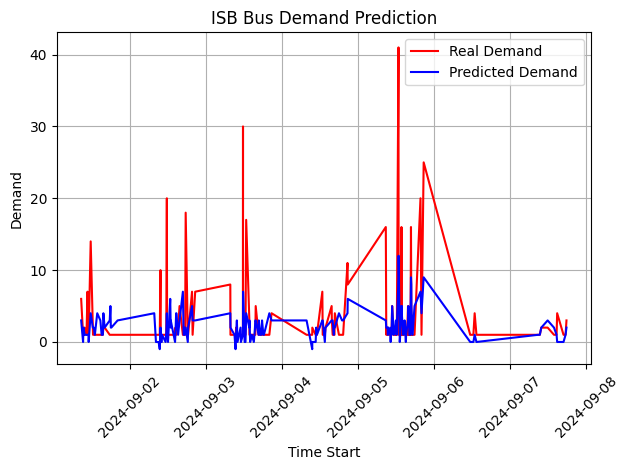

MAE: 2.2887700534759357
MSE: 22.39572192513369


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute,predicted_count
30,6,A2,Opp KR MRT,2024-09-01 08:46:00,Monday,0,0,8,46,3.0
68,1,A2,Opp KR MRT,2024-09-01 09:22:00,Monday,0,0,9,22,-0.0
82,1,A2,Opp KR MRT,2024-09-01 09:30:00,Monday,0,1,9,30,2.0
129,2,A2,Opp KR MRT,2024-09-01 09:51:00,Monday,0,1,9,51,1.0
158,1,A2,Opp KR MRT,2024-09-01 10:27:00,Monday,0,0,10,27,1.0
...,...,...,...,...,...,...,...,...,...,...
5541,1,A2,Opp KR MRT,2024-09-07 14:35:00,Sunday,1,1,14,35,1.0
5544,4,A2,Opp KR MRT,2024-09-07 14:46:00,Sunday,1,1,14,46,-0.0
5621,1,A2,Opp KR MRT,2024-09-07 16:46:00,Sunday,1,1,16,46,-0.0
5630,1,A2,Opp KR MRT,2024-09-07 17:25:00,Sunday,1,0,17,25,1.0


In [ ]:
from sklearn.metrics import mean_squared_error 

a2 = df[(df['ISB_Service'] == 'A2')]
a2_Opp_KR_MRT = a2[(a2['bus_stop_board'] == 'Opp KR MRT')]
a2_Opp_KR_MRT['predicted_count'] = np.ceil(a2_Opp_KR_MRT['predicted_count'])

# Assuming 'time_start' is the column you want to use for the x-axis
plt.plot(a2_Opp_KR_MRT['time_start'], a2_Opp_KR_MRT['count'], color='red', label='Real Demand')
plt.plot(a2_Opp_KR_MRT['time_start'], a2_Opp_KR_MRT['predicted_count'], color='blue', label='Predicted Demand')

plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time Start')  # x-axis label will be 'Time Start'
plt.ylabel('Demand')      # y-axis label will remain 'Demand'
plt.legend()
plt.xticks(rotation=45)  # Optional: Rotate the x-axis labels for better readability if needed
plt.grid(True)
plt.tight_layout()  # Ensures the labels fit well if there's any issue with the layout
plt.show()

from sklearn.metrics import mean_absolute_error

mae_a2 = mean_absolute_error(a2_Opp_KR_MRT['count'], a2_Opp_KR_MRT['predicted_count'])

print("MAE:", mae_a2)

a2_Opp_KR_MRT

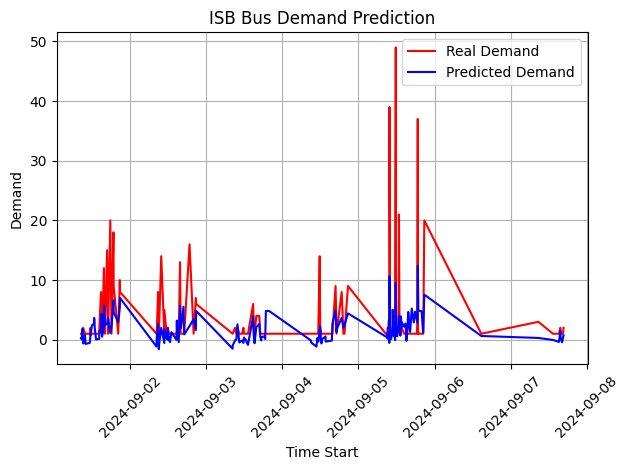

MAE: 2.725659471941558


,count,ISB_Service,bus_stop_board,time_start,day_of_the_week,is_weekend,is_peak,hour,minute,predicted_count
5,1,D1,UTown,2024-09-01 08:28:00,Monday,0,0,8,28,0.207760
13,1,D1,UTown,2024-09-01 08:39:00,Monday,0,0,8,39,0.106893
34,1,D1,UTown,2024-09-01 08:55:00,Monday,0,0,8,55,1.843496
40,1,D1,UTown,2024-09-01 09:02:00,Monday,0,0,9,2,-0.051241
52,2,D1,UTown,2024-09-01 09:09:00,Monday,0,0,9,9,-0.631454
...,...,...,...,...,...,...,...,...,...,...
5575,2,D1,UTown,2024-09-07 15:42:00,Sunday,1,1,15,42,1.508325
5585,1,D1,UTown,2024-09-07 15:46:00,Sunday,1,1,15,46,0.299907
5594,1,D1,UTown,2024-09-07 16:14:00,Sunday,1,0,16,14,-0.434674
5601,1,D1,UTown,2024-09-07 16:31:00,Sunday,1,1,16,31,0.312036


In [ ]:
d1 = df[(df['ISB_Service'] == 'D1')]


d1_UTown = d1[(d1['bus_stop_board'] == 'UTown')]

# Assuming 'time_start' is the column you want to use for the x-axis
plt.plot(d1_UTown['time_start'], d1_UTown['count'], color='red', label='Real Demand')
plt.plot(d1_UTown['time_start'], d1_UTown['predicted_count'], color='blue', label='Predicted Demand')

plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time Start')  # x-axis label will be 'Time Start'
plt.ylabel('Demand')      # y-axis label will remain 'Demand'
plt.legend()
plt.xticks(rotation=45)  # Optional: Rotate the x-axis labels for better readability if needed
plt.grid(True)
plt.tight_layout()  # Ensures the labels fit well if there's any issue with the layout
plt.show()

from sklearn.metrics import mean_absolute_error
mae_d1 = mean_absolute_error(d1_UTown['count'], d1_UTown['predicted_count'])
print("MAE:", mae_d1)

d1_UTown


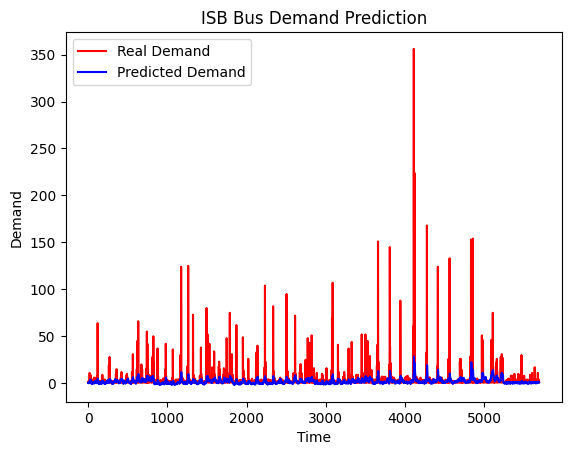

MAE: 2.8138626525601547


In [ ]:
plt.plot(original, color = 'red', label = 'Real Demand')
plt.plot(pred, color = 'blue', label = 'Predicted Demand')
plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(original, pred)
print("MAE:", mae)



In [ ]:
import pandas as pd
from datetime import datetime, timedelta

columns = ['count', 'ISB_Service', 'bus_stop_board', 'day_of_the_week', 'is_weekend', 'is_peak', 'hour', 'minute']

base_df = pd.DataFrame(columns = columns)

dates = pd.date_range("2024-09-15", "2024-09-21", freq="D")

# Initialize an empty list to store all the datetime rows
datetime_rows = []

# Loop through each date
for date in dates:
    # Set the start and end times for each day
    start_time = datetime.combine(date, datetime.min.time()) + timedelta(hours=7, minutes = 15)  # 7:00 AM
    end_time = datetime.combine(date, datetime.min.time()) + timedelta(hours=23)  # 11:00 PM

    # Initialize the current time for the loop
    current_time = start_time

    # Loop through every 5 minutes for the current date
    while current_time <= end_time:
        # Append the current time to the list in the format YYYY-MM-DD HH:MM:SS
        datetime_rows.append(current_time.strftime("%Y-%m-%d %H:%M:%S"))
        
        # Increment the current time by 5 minutes
        current_time += timedelta(minutes=1)

# Create a DataFrame with the datetime values in a column
time_df = pd.DataFrame(datetime_rows, columns=["DateTime"])

base_df['time_start'] = time_df

base_df

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:15:00
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:16:00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:17:00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:18:00
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:19:00
...,...,...,...,...,...,...,...,...,...
6617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21 22:56:00
6618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21 22:57:00
6619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21 22:58:00
6620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21 22:59:00


In [ ]:

A1_bus = ['KR Bus Terminal', 'LT13', 'AS5', 'BIZ2', 'Opp TCOMS', 'PGP Terminal', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'YIH', 'CLB', 'KR Bus Terminal']
A2_bus = ['KR Bus Terminal', 'IT', 'Opp YIH', 'Museum', 'UHC', 'Opp University Hall', 'S17', 'Opp KR MRT', 'PGP Foyer', 'TCOMS', 'Opp HSSML', 'Opp NUSS', 'Ventus', 'KR Bus Terminal']
D1_bus = ['COM3', 'Opp HSSML', 'Opp NUSS', 'Ventus', 'IT', 'Opp YIH', 'Museum', 'UTown', 'YIH', 'CLB', 'LT13', 'AS5', 'BIZ2', 'COM3']
D2_bus = ['COM3', 'Opp TCOMS', 'PGP Terminal', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'Museum', 'UTown', 'UHC', 'Opp University Hall', 'S17', 'Opp KR MRT', 'PGP Foyer', 'TCOMS', 'COM3']
BTC_bus = ['Oei Tiong Ham Building (BTC)', 'Botanic Gardens MRT (BTC)', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'UTown', 'Raffles Hall', 'Kent Vale', 'Museum', 'YIH', 'CLB', 'LT13', 'AS5', 'BIZ2', 'PGP Terminal', 'College Green (BTC)', 'Oei Tiong Ham Building (BTC)']
E_bus = ['UTown', 'Raffles Hall', 'Kent Vale', 'EA', 'SDE3', 'IT', 'Opp YIH', 'UTown']
K_bus = ['PGP Terminal', 'KR MRT', 'LT27', 'University Hall', 'Opp UHC', 'YIH', 'CLB', 'Opp SDE3', 'The Japanese Primary School', 'Kent Vale', 'Museum', 'UHC', 'Opp University Hall', 'S17', 'Opp KR MRT', 'PGP Foyer']
L_bus = ['Oei Tiong Ham Building (BTC)', 'Botanic Gardents MRT (BTC)', 'College Green (BTC)', 'Oei Tiong Ham Building (BTC)']

bus_routes = {'A1':A1_bus, 'A2':A2_bus, 'D1':D1_bus, 'D2':D2_bus, 'BTC (Bukit Timah Campus)':BTC_bus, 'E':E_bus, 'K':K_bus, 'L':L_bus}

# Initialize an empty list to store the new rows
new_rows = []

# Loop through each bus route and fill the data
for bus, stops in bus_routes.items():
    for stop in stops:
        # Create a new DataFrame based on base_df
        temp_df = base_df.copy()
        # Set ISB_Service and bus_stop_board values
        temp_df['ISB_Service'] = bus
        temp_df['bus_stop_board'] = stop
        # Append each row as a dictionary to the list
        new_rows.extend(temp_df.to_dict(orient='records'))


future_df = pd.DataFrame()
# Concatenate all the new rows with future_df at once
future_df = pd.concat([future_df, pd.DataFrame(new_rows)], ignore_index=True)


future_df

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start
0,NaN,A1,KR Bus Terminal,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:15:00
1,NaN,A1,KR Bus Terminal,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:16:00
2,NaN,A1,KR Bus Terminal,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:17:00
3,NaN,A1,KR Bus Terminal,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:18:00
4,NaN,A1,KR Bus Terminal,NaN,NaN,NaN,NaN,NaN,2024-09-15 07:19:00
...,...,...,...,...,...,...,...,...,...
682061,NaN,L,Oei Tiong Ham Building (BTC),NaN,NaN,NaN,NaN,NaN,2024-09-21 22:56:00
682062,NaN,L,Oei Tiong Ham Building (BTC),NaN,NaN,NaN,NaN,NaN,2024-09-21 22:57:00
682063,NaN,L,Oei Tiong Ham Building (BTC),NaN,NaN,NaN,NaN,NaN,2024-09-21 22:58:00
682064,NaN,L,Oei Tiong Ham Building (BTC),NaN,NaN,NaN,NaN,NaN,2024-09-21 22:59:00


In [ ]:

future_df['time_start'] = pd.to_datetime(future_df['time_start'])

def assign_dayofweek(row):
    date = str(row['time_start'].date())

    if date == '2024-09-15':
        return 'Monday'  
    elif date == '2024-09-16':
        return 'Tuesdays'
    elif date == '2024-09-17':
        return 'Wednesdays'
    elif date == '2024-09-18':
        return 'Thursdays'
    elif date == '2024-09-19':
        return 'Fridays'
    elif date == '2024-09-20':
        return 'Saturday'
    else:
        return 'Sunday' 


# Apply the function to create a new date column
future_df['day_of_the_week'] = future_df.apply(assign_dayofweek, axis=1)
future_df['is_weekend'] = future_df.apply(assign_weekend, axis=1)
future_df['is_peak'] = future_df.apply(assign_peak, axis=1)
future_df['hour'] = future_df.apply(assign_hour, axis=1)
future_df['minute'] = future_df.apply(assign_minute, axis=1)



future_df

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start
0,NaN,A1,KR Bus Terminal,Monday,0,0,7,15,2024-09-15 07:15:00
1,NaN,A1,KR Bus Terminal,Monday,0,0,7,16,2024-09-15 07:16:00
2,NaN,A1,KR Bus Terminal,Monday,0,0,7,17,2024-09-15 07:17:00
3,NaN,A1,KR Bus Terminal,Monday,0,0,7,18,2024-09-15 07:18:00
4,NaN,A1,KR Bus Terminal,Monday,0,0,7,19,2024-09-15 07:19:00
...,...,...,...,...,...,...,...,...,...
682061,NaN,L,Oei Tiong Ham Building (BTC),Sunday,1,0,22,56,2024-09-21 22:56:00
682062,NaN,L,Oei Tiong Ham Building (BTC),Sunday,1,0,22,57,2024-09-21 22:57:00
682063,NaN,L,Oei Tiong Ham Building (BTC),Sunday,1,0,22,58,2024-09-21 22:58:00
682064,NaN,L,Oei Tiong Ham Building (BTC),Sunday,1,0,22,59,2024-09-21 22:59:00


In [ ]:
old_df = grouped_data

label_encoder_bsb_f = preprocessing.LabelEncoder() 
label_encoder_ISBS_f = preprocessing.LabelEncoder() 
label_encoder_dotw_f = preprocessing.LabelEncoder()


old_df['bus_stop_board']= label_encoder_bsb_f.fit_transform(old_df['bus_stop_board']) 
future_df['bus_stop_board']= label_encoder_bsb_f.fit_transform(future_df['bus_stop_board'])  
 
old_df['day_of_the_week']= label_encoder_dotw_f.fit_transform(old_df['day_of_the_week']) 
future_df['day_of_the_week']= label_encoder_dotw_f.fit_transform(future_df['day_of_the_week']) 

old_df['ISB_Service']= label_encoder_ISBS_f.fit_transform(old_df['ISB_Service'])
future_df['ISB_Service']= label_encoder_ISBS_f.fit_transform(future_df['ISB_Service'])


future_df = future_df.sort_values(by='time_start')
full_df = pd.concat([old_df, future_df])
full_df = full_df.drop('time_start', axis=1)

full_df_scaled = scaler.fit_transform(full_df)
full_df_scaled_array = full_df_scaled.copy()

full_df

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute
0,2.0,4,6,1,0,0,7,45
1,1.0,0,0,1,0,0,7,46
2,4.0,4,12,1,0,0,7,46
3,4.0,0,23,1,0,0,7,46
4,3.0,0,17,1,0,0,7,46
...,...,...,...,...,...,...,...,...
158927,NaN,1,16,3,1,0,23,0
516515,NaN,5,11,3,1,0,23,0
165549,NaN,1,18,3,1,0,23,0
145683,NaN,1,24,3,1,0,23,0


In [ ]:
# Get the scaled values as an array
all_data = []
time_step = 30

# Handle NaN in the target column before processing
full_df_scaled_array[:, 0] = np.nan_to_num(full_df_scaled_array[:, 0], nan=0)

# Prepare the input data (X) for the LSTM model
X = [full_df_scaled_array[i - time_step:i, :] for i in range(time_step, len(full_df_scaled_array))]
X = np.array(X)

# Make predictions in batch
predictions = best_model.predict(X)

# Flatten predictions to ensure they match the shape of the counts column
predictions = predictions.flatten()



43821/43821 ━━━━━━━━━━━━━━━━━━━━ 496s 11ms/step


In [ ]:
predictions.shape

(701125,)

In [ ]:
# Step 1: Reshape predictions for inverse scaling
predictions = np.array(predictions).reshape(-1, 1)

# Step 2: Repeat predictions across all columns to match scaler's expected input shape
prediction_copies_array = np.repeat(predictions, full_df.shape[1], axis=-1)

# Step 3: Apply inverse transform to bring predictions back to the original scale
y_pred_rescaled = scaler.inverse_transform(prediction_copies_array)[:, 0]  # Only the 'count' column

future_predicted_count = future_df
future_predicted_count['predicted_count'] = y_pred_rescaled[19059:]

future_predicted_count

,count,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start,predicted_count
0,NaN,0,9,1,0,0,7,15,2024-09-15 07:15:00,0.499716
218526,NaN,3,14,1,0,0,7,15,2024-09-15 07:15:00,0.032908
278124,NaN,4,20,1,0,0,7,15,2024-09-15 07:15:00,-0.259255
403942,NaN,2,33,1,0,0,7,15,2024-09-15 07:15:00,-0.231968
185416,NaN,3,16,1,0,0,7,15,2024-09-15 07:15:00,0.456610
...,...,...,...,...,...,...,...,...,...,...
158927,NaN,1,16,3,1,0,23,0,2024-09-21 23:00:00,-0.730908
516515,NaN,5,11,3,1,0,23,0,2024-09-21 23:00:00,-0.884115
165549,NaN,1,18,3,1,0,23,0,2024-09-21 23:00:00,-0.966958
145683,NaN,1,24,3,1,0,23,0,2024-09-21 23:00:00,-1.062821


In [ ]:
# Inverse transform each feature column
future_predicted_count['bus_stop_board'] = label_encoder_bsb_f.inverse_transform(future_predicted_count['bus_stop_board'])
future_predicted_count['ISB_Service'] = label_encoder_ISBS_f.inverse_transform(future_predicted_count['ISB_Service'])
future_predicted_count['day_of_the_week'] = label_encoder_dotw_f.inverse_transform(future_predicted_count['day_of_the_week'])

future_predicted_count = future_predicted_count.drop(columns=["count"])
future_predicted_count

,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start,predicted_count
0,A1,KR Bus Terminal,Monday,0,0,7,15,2024-09-15 07:15:00,0.499716
218526,D1,Museum,Monday,0,0,7,15,2024-09-15 07:15:00,0.032908
278124,D2,Opp TCOMS,Monday,0,0,7,15,2024-09-15 07:15:00,-0.259255
403942,BTC (Bukit Timah Campus),University Hall,Monday,0,0,7,15,2024-09-15 07:15:00,-0.231968
185416,D1,Opp HSSML,Monday,0,0,7,15,2024-09-15 07:15:00,0.456610
...,...,...,...,...,...,...,...,...,...
158927,A2,Opp HSSML,Sunday,1,0,23,0,2024-09-21 23:00:00,-0.730908
516515,E,Kent Vale,Sunday,1,0,23,0,2024-09-21 23:00:00,-0.884115
165549,A2,Opp NUSS,Sunday,1,0,23,0,2024-09-21 23:00:00,-0.966958
145683,A2,PGP Foyer,Sunday,1,0,23,0,2024-09-21 23:00:00,-1.062821


In [ ]:
future_predicted_count['predicted_count'] = future_predicted_count['predicted_count'].apply(lambda x: max(x, 0))

negative_count = (future_predicted_count['predicted_count'] < 0).sum()

print(f"Number of negative values in 'predicted_count':", negative_count)

Number of negative values in 'predicted_count': 0


In [ ]:

negative_count = (future_predicted_count['predicted_count'] == 0).sum()

print(f"Number of negative values in 'predicted_count':", negative_count)

Number of negative values in 'predicted_count': 87363


In [ ]:
#future_predicted_count.to_csv('future_predicted_data.csv', index=False)

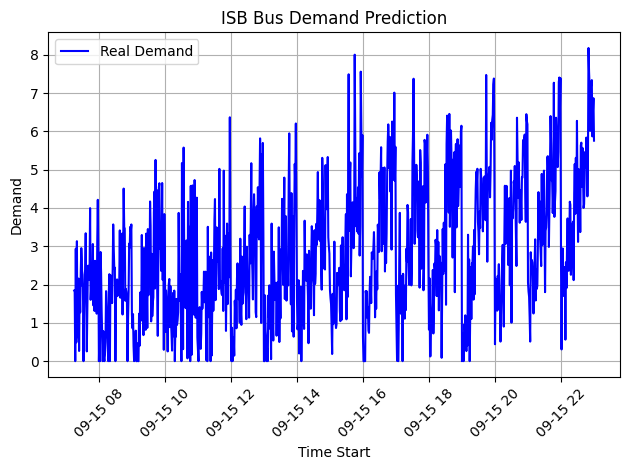

,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start,predicted_count
152306,A2,Opp HSSML,Monday,0,0,7,15,2024-09-15 07:15:00,1.228015
132440,A2,Opp KR MRT,Monday,0,0,7,15,2024-09-15 07:15:00,0.612629
99330,A2,Opp YIH,Monday,0,0,7,15,2024-09-15 07:15:00,0.743787
119196,A2,Opp University Hall,Monday,0,0,7,15,2024-09-15 07:15:00,2.499676
92708,A2,IT,Monday,0,0,7,15,2024-09-15 07:15:00,1.153041
...,...,...,...,...,...,...,...,...,...
140007,A2,PGP Foyer,Monday,0,0,23,0,2024-09-15 23:00:00,0.745452
93653,A2,IT,Monday,0,0,23,0,2024-09-15 23:00:00,1.574250
106897,A2,Museum,Monday,0,0,23,0,2024-09-15 23:00:00,0.269245
100275,A2,Opp YIH,Monday,0,0,23,0,2024-09-15 23:00:00,2.004962


In [ ]:
a2_future = future_predicted_count[(future_predicted_count['ISB_Service'] == 'A2')]
a2_future = a2_future[(a2_future['day_of_the_week'] == 'Monday')]
a2_Opp_KR_MRT_future = a2_future[(a2_future['bus_stop_board'] == 'Opp NUSS')]

# Assuming 'time_start' is the column you want to use for the x-axis
plt.plot(a2_Opp_KR_MRT_future['time_start'], a2_Opp_KR_MRT_future['predicted_count'], color='blue', label='Real Demand')
#plt.plot(a2_Opp_KR_MRT_future['time_start'], a2_Opp_KR_MRT_future['predicted_count'], color='blue', label='Predicted Demand')

plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time Start')  # x-axis label will be 'Time Start'
plt.ylabel('Demand')      # y-axis label will remain 'Demand'
plt.legend()
plt.xticks(rotation=45)  # Optional: Rotate the x-axis labels for better readability if needed
plt.grid(True)
plt.tight_layout()  # Ensures the labels fit well if there's any issue with the layout
plt.show()

a2_future

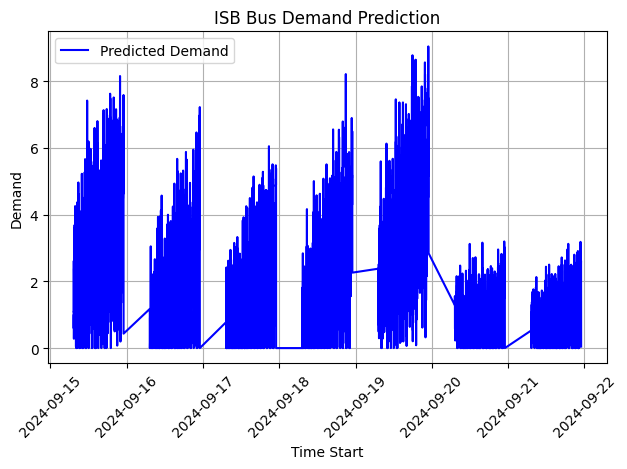

,ISB_Service,bus_stop_board,day_of_the_week,is_weekend,is_peak,hour,minute,time_start,predicted_count
152306,A2,Opp HSSML,Monday,0,0,7,15,2024-09-15 07:15:00,1.228015
132440,A2,Opp KR MRT,Monday,0,0,7,15,2024-09-15 07:15:00,0.612629
99330,A2,Opp YIH,Monday,0,0,7,15,2024-09-15 07:15:00,0.743787
119196,A2,Opp University Hall,Monday,0,0,7,15,2024-09-15 07:15:00,2.499676
92708,A2,IT,Monday,0,0,7,15,2024-09-15 07:15:00,1.153041
...,...,...,...,...,...,...,...,...,...
140007,A2,PGP Foyer,Monday,0,0,23,0,2024-09-15 23:00:00,0.745452
93653,A2,IT,Monday,0,0,23,0,2024-09-15 23:00:00,1.574250
106897,A2,Museum,Monday,0,0,23,0,2024-09-15 23:00:00,0.269245
100275,A2,Opp YIH,Monday,0,0,23,0,2024-09-15 23:00:00,2.004962


In [ ]:
d2_future = future_predicted_count[(future_predicted_count['ISB_Service'] == 'D2')]
d2_KR_MRT_future = d2_future[(d2_future['bus_stop_board'] == 'KR MRT')]

# Assuming 'time_start' is the column you want to use for the x-axis
plt.plot(d2_KR_MRT_future['time_start'], d2_KR_MRT_future['predicted_count'], color='blue', label='Predicted Demand')
#plt.plot(a2_Opp_KR_MRT_future['time_start'], a2_Opp_KR_MRT_future['predicted_count'], color='blue', label='Predicted Demand')

plt.title('ISB Bus Demand Prediction')
plt.xlabel('Time Start')  # x-axis label will be 'Time Start'
plt.ylabel('Demand')      # y-axis label will remain 'Demand'
plt.legend()
plt.xticks(rotation=45)  # Optional: Rotate the x-axis labels for better readability if needed
plt.grid(True)
plt.tight_layout()  # Ensures the labels fit well if there's any issue with the layout
plt.show()

a2_future

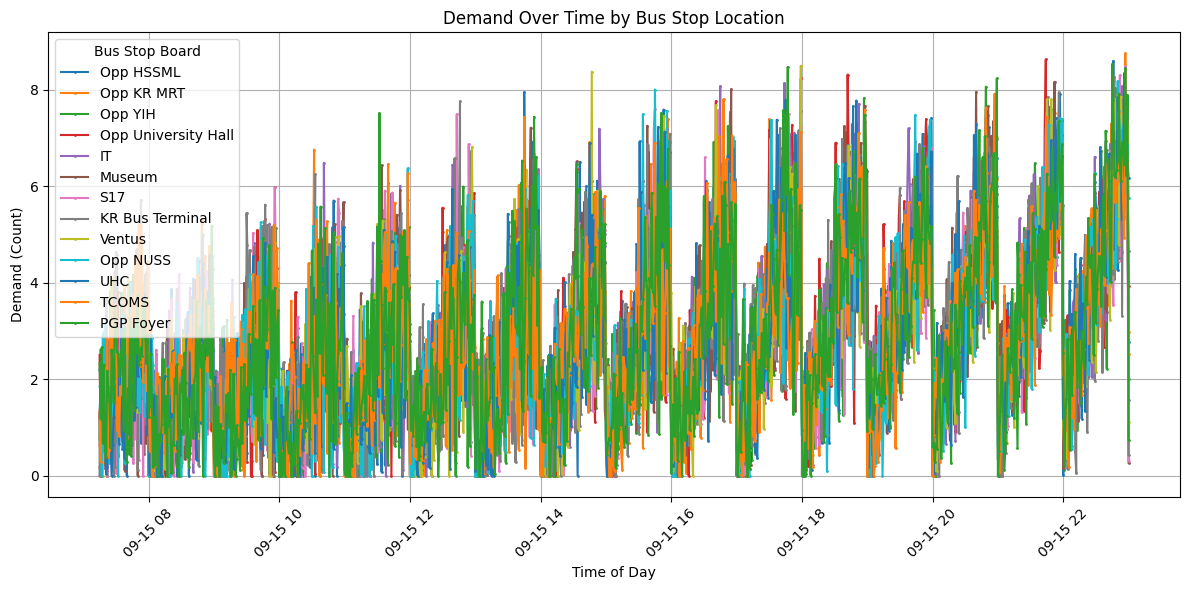

In [ ]:
# Plotting
plt.figure(figsize=(12, 6))
for bus_stop_board in a2_future['bus_stop_board'].unique():
    subset = a2_future[a2_future['bus_stop_board'] == bus_stop_board]
    plt.plot(subset['time_start'], subset['predicted_count'], label = bus_stop_board, marker='o', markersize=1)

# Configure plot labels and title
plt.title('Demand Over Time by Bus Stop Location')
plt.xlabel('Time of Day')
plt.ylabel('Demand (Count)')
plt.xticks(rotation = 45)
plt.legend(title='Bus Stop Board')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
